# COCO Data Generator for Semantic Segmentation
_Viraf Patrawala (March, 2020)_

The [**COCO (Common Objects in Context)**](http://cocodataset.org/#home "COCO Homepage") dataset consists of [80 output classes](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda). This labelled dataset can be used for image classification, segmentation and captioning problems.
![image.png](attachment:image.png)

Here we first have a quick introduction to how [pycoco](https://pypi.org/project/pycoco/#description) works and then, we create a data generator object using [pycoco](https://pypi.org/project/pycoco/#description) and [tensorflow keras](https://www.tensorflow.org/guide/keras) to ease training models on the COCO dataset.


### Goals
1) Get subsets of the COCO dataset as per requirement  
2) Generate masks from the given COCO annotations  
3) Add image augmentations  
4) Create a data generator object to ease training models


___

You can have a look at the [Pycoco demo notebook](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) first to get a better understanding of the following code.

## STEP 1: Download and Arrange the data

[Download](http://cocodataset.org/#download "Download COCO") the following files on to your PC. 

**2017 train images, 2017 val images, 2017 Train/Val annotations**

(Since the files are quite large, they might take some time, so be patient.)

Some simple re-arrangement and re-naming of folders is required as below. The file structure for the following code is:
```
Project Folder
└───this code notebook
│
└───COCOdataset2017   
    └───images
    │   └───train
    │   │    │   000000000009.jpg
    │   │    │   000000000025.jpg
    │   │    │   ...
    │   └───val   
    │        │   000000000139.jpg
    │        │   000000000285.jpg
    │        │   ...
    └───annotations
        │   instances_train.json
        │   instances_val.json
```

## STEP 2: Install and Import Required Libraries

Have a look at the import statements below. Install any module you might not already have. 

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## For visualizing results
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## STEP 3: Dataset Exploration with PyCoCO

In [ ]:
dataDir='/content/drive/MyDrive/CV/l4/data'
dataType='val'
annFile='{}/annotations/instances_{}2017.json'.format(dataDir,dataType)

# initialize the COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [ ]:
# display COCO categories and supercategories
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

nms=[cat['name'] for cat in cats]
print(len(nms),'COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print(len(nms),'COCO supercategories: \n{}'.format(' '.join(nms)))

80 COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

12 COCO supercategories: 
furniture outdoor person appliance indoor kitchen electronic animal accessory sports vehicle food


### COCO Class Ids

As mentioned before, COCO has 80 classes (and a background class). However, the labels for the 80 classes range from 0 to 90 (some empty id numbers in between). Here is a convenient function which can fetch a class name for a given id number.

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

print('The class name is', getClassName(77, cats))

The class name is cell phone




#### Class Filtering
Many times, you might not want to use all the [80 output classes](https://gist.github.com/AruniRC/7b3dadd004da04c80198557db5da4bda) provided by COCO. This method is used for filtering out images from the dataset of classes that you want.


In [ ]:
# get all images containing given categories, select one at random
filterClasses = ['person']
catIds = coco.getCatIds(catNms=filterClasses);
imgIds = coco.getImgIds(catIds=catIds);

print("Number of images containing all required classes:", len(imgIds))

Number of images containing all required classes: 2693


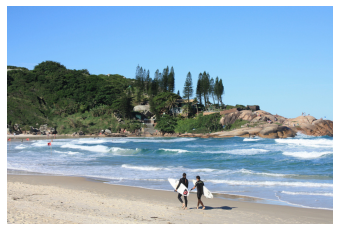

In [ ]:
# load and display image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0
# Or use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

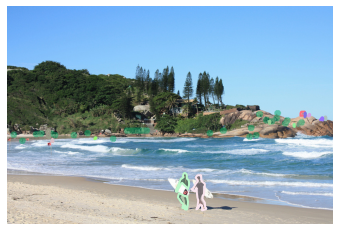

In [ ]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

#### All Possible Combinations

When we filter the dataset with classes, the pycoco tool assumes that you want *all the classes in the image*, which is why it returns images with only ALL your required classes, not one or two or other combinations.

Thus, this piece of code will ensure that all possible combinations for the given class lists are obtained in the resultant dataset.

See how above, we had received only 11 images, but now there are 503 images!

In [ ]:
########## ALl POSSIBLE COMBINATIONS ########
classes = ['laptop', 'tv', 'cell phone']

images = []
if classes!=None:
    # iterate for each individual class in the list
    for className in classes:
        # get all images containing given class
        catIds = coco.getCatIds(catNms=className)
        imgIds = coco.getImgIds(catIds=catIds)
        images += coco.loadImgs(imgIds)
else:
    imgIds = coco.getImgIds()
    images = coco.loadImgs(imgIds)
    
# Now, filter out the repeated images    
unique_images = []
for i in range(len(images)):
    if images[i] not in unique_images:
        unique_images.append(images[i])

dataset_size = len(unique_images)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 503


## Step 4: Create A Mask

#### (a) Normal Mask
In the mask created below, each pixel has a label according to the class it falls into.

For example,  
0: background  
1: laptop  
2: tv  
3: cell phone

Note that I am not using the official COCO ids, but instead allotting pixel values as per the order of the class name in the array 'filterClasses'.  
I have written the code according to the above scheme. Feel free to edit it as per your label needs.

Unique pixel values in the mask are: [0. 1.]


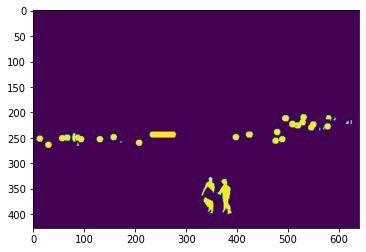

In [ ]:
#### GENERATE A SEGMENTATION MASK ####
filterClasses = ['person']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

#### (b) Binary Masking

In general, your output mask will _N_ possible pixel values for N output classes. However, binary masking implies that the output mask will have **only 2 pixel values**, i.e., 0 will represent the background and 1 will represent the objects.

Unique pixel values in the mask are: [0. 1.]


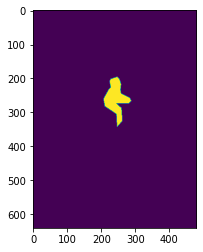

In [ ]:
#### GENERATE BINARY MASK ####

mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    mask = np.maximum(coco.annToMask(anns[i]), mask)
plt.imshow(mask)

print('Unique pixel values in the mask are:', np.unique(mask))

## STEP 5: Combine

Now we mix all these concepts to create our data generator.

### (a) Filter the Dataset

The filterDataset function takes 3 inputs-  
(a) **folder**: the folder containing the dataset  
(b) **classes**: a list object if you want specific output classes or None  
(c) **mode**: 'train' or 'val' 

The function returns-  
a) **images**: a list containing all the filtered image objects  
b) **dataset_size**: The size of the generated filtered dataset  
c) **coco**: The initialized coco object  

In [ ]:
def filterDataset(folder, classes=None, mode='val'):    
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}2017.json'.format(folder, mode)
    coco = COCO(annFile)
    
    images = []
    if classes!=None:
        # iterate for each individual class in the list
        for className in classes:
            # get all images containing given categories
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)
    
    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco

In [ ]:
folder = '/content/drive/MyDrive/CV/l4/data'
classes = ['person']
mode = 'val'

images, dataset_size, coco = filterDataset(folder, classes,  mode)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!


### (b) Generate the Image and mask

The dataGeneratorCoco function takes 8 inputs-   
(a) **images**: the image list returned by the filterDataset function  
(b) **classes**: the filter classes list  
(c) **coco**: the coco object returned by the filterDataset function  
(d) **folder**: the folder containing the dataset  
(e) **input_image_size**: size of input image to your model (width, height)  
(f) **batch_size**: batch size  
(g) **mode**: 'train' or 'val'  
(h) **mask_type**: 'binary' or 'normal'(classes can't be None) 


The function returns a data generator object yielding batches of images and their corresponding masks

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return None

def getImage(imageObj, img_folder, input_image_size):
    # Read and normalize an image
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    # Resize
    train_img = cv2.resize(train_img, input_image_size)
    if (len(train_img.shape)==3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # To handle a black and white image, increase dimensions to 3
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img
    
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask  
    
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask


def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4, mode='train', mask_type='binary'):
    
    img_folder = '{}/images/{}'.format(folder, mode)
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while(True):
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
batch_size = 8
input_image_size = (256,256)
mask_type = 'normal'

val_gen = dataGeneratorCoco(images, classes, coco, folder,
                            input_image_size, batch_size, mode, mask_type)

Our generator is finally ready, let's define a function to visualize it.

In [ ]:
def visualizeGenerator(gen):
    img, mask = next(gen)
    
    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2,
                        subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j])
            else:
                ax.imshow(mask[j][:,:,0])
                
            ax.axis('off')
            fig.add_subplot(ax)        
    plt.show()

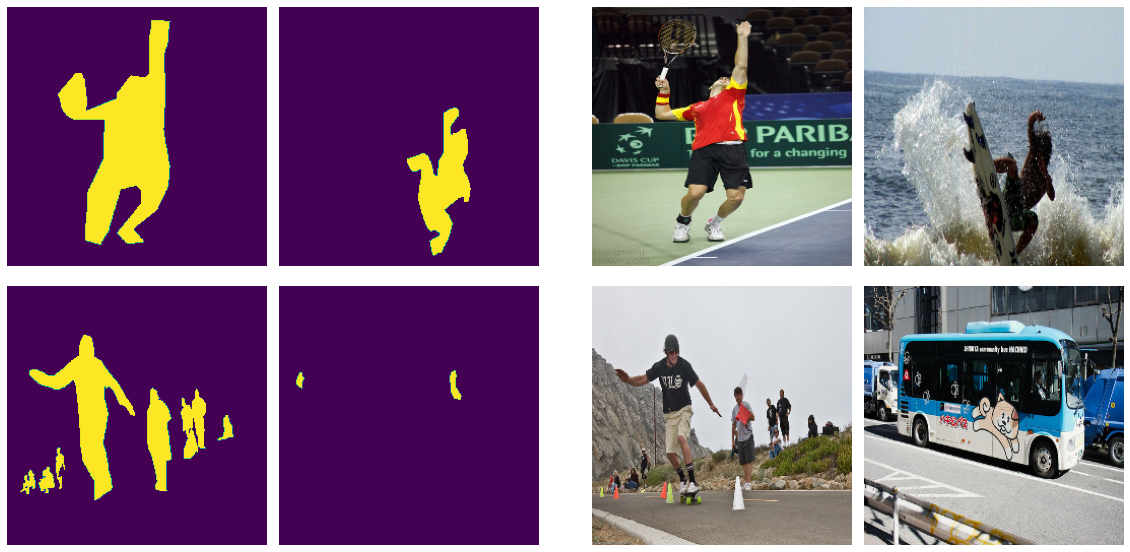

In [ ]:
visualizeGenerator(val_gen)

## STEP 6: Augmentations

With the above 5 steps, our COCO data generator is already ready! But, if you wish to add data augmentations to your images to increase potential dataset size, follow the code below!

The augmentationsGenerator function takes 3 inputs-   
(a) **gen**: the generator object to which you wish to add augmentations  
(b) **augGeneratorArgs**: the augmentation arguments (see the code example ahead)  
(c) **seed**: seed to generate the random augmentation parameters or None  

The output of the function is a data generator object yielding batches of augmented images and correspondingly augmented binary masks.

In [ ]:
def augmentationsGenerator(gen, augGeneratorArgs, seed=None):
    # Initialize the image data generator with args provided
    image_gen = ImageDataGenerator(**augGeneratorArgs)
    
    # Remove the brightness argument for the mask. Spatial arguments similar to image.
    augGeneratorArgs_mask = augGeneratorArgs.copy()
    _ = augGeneratorArgs_mask.pop('brightness_range', None)
    # Initialize the mask data generator with modified args
    mask_gen = ImageDataGenerator(**augGeneratorArgs_mask)
    
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    
    for img, mask in gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation of the images 
        # will end up different from the augmentation of the masks
        g_x = image_gen.flow(255*img, 
                             batch_size = img.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = mask_gen.flow(mask, 
                             batch_size = mask.shape[0], 
                             seed = seed, 
                             shuffle=True)
        
        img_aug = next(g_x)/255.0
        
        mask_aug = next(g_y)
                   

        yield img_aug, mask_aug

In [ ]:
augGeneratorArgs = dict(featurewise_center = False, 
                        samplewise_center = False,
                        rotation_range = 5, 
                        width_shift_range = 0.01, 
                        height_shift_range = 0.01, 
                        brightness_range = (0.8,1.2),
                        shear_range = 0.01,
                        zoom_range = [1, 1.25],  
                        horizontal_flip = True, 
                        vertical_flip = False,
                        fill_mode = 'reflect',
                        data_format = 'channels_last')

aug_gen = augmentationsGenerator(val_gen, augGeneratorArgs)

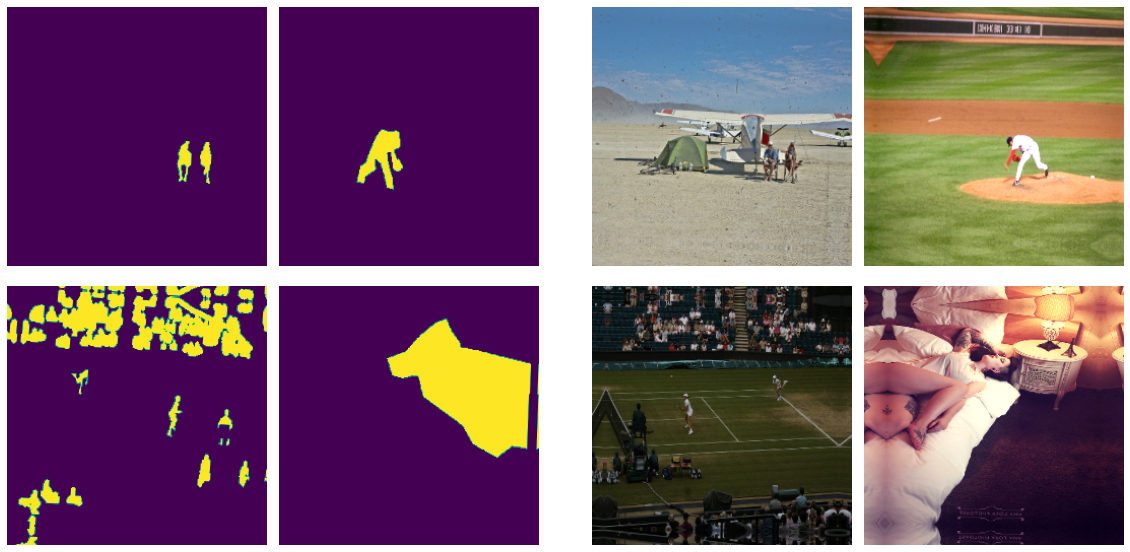

In [ ]:
visualizeGenerator(aug_gen)

## Finally...

There, your image data generator with augmentations is now ready! What can you do with it now? Here is a quick example showing how easily you can use it to train a model!

In [ ]:
-> Create filtered train dataset (using filterDataset()) 
-> Create filtered val dataset (using filterDataset()) 

-> Create train generator (using dataGeneratorCoco()) 
-> Create train generator (using dataGeneratorCoco()) 

# Set your parameters
n_epochs = <number of epochs of training>

steps_per_epoch = dataset_size_train // batch_size
validation_steps = dataset_size_val // batch_size

m = <your model>
opt = <your optimizer>
lossFn = <your loss function>

# Compile your model first
m.compile(loss = lossFn, optimizer = opt, metrics=['accuracy'])

# Start the training process
history = m.fit(x = train_gen_aug,
                validation_data = val_gen_aug,
                steps_per_epoch = steps_per_epoch,
                validation_steps = validation_steps,
                epochs = n_epochs,
                verbose = True)

In [ ]:
def build_model():
    x = tf.keras.layers.Input((256, 256, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [ ]:

#BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics='accuracy' )
steps_per_epoch = 2693 // batch_size


Epoch 1/30
336/336 [==============================] - 153s 451ms/step - loss: 0.4603 - accuracy: 0.8296
Epoch 2/30
336/336 [==============================] - 154s 459ms/step - loss: 0.4142 - accuracy: 0.8368
Epoch 3/30
336/336 [==============================] - 154s 459ms/step - loss: 0.4112 - accuracy: 0.8294
Epoch 4/30
336/336 [==============================] - 154s 459ms/step - loss: 0.4030 - accuracy: 0.8339
Epoch 5/30
336/336 [==============================] - 153s 456ms/step - loss: 0.4042 - accuracy: 0.8275
Epoch 6/30
336/336 [==============================] - 153s 455ms/step - loss: 0.3961 - accuracy: 0.8242
Epoch 7/30
336/336 [==============================] - 153s 456ms/step - loss: 0.3795 - accuracy: 0.8307
Epoch 8/30
336/336 [==============================] - 153s 456ms/step - loss: 0.3612 - accuracy: 0.8411
Epoch 9/30
336/336 [==============================] - 153s 456ms/step - loss: 0.3779 - accuracy: 0.8382
Epoch 10/30
336/336 [==============================] - 153s 456m

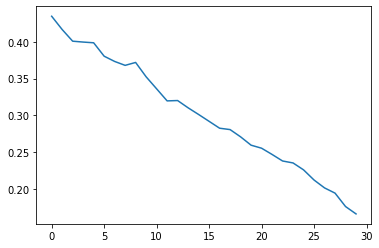

In [ ]:
NUM_EPOCHS = 30
hist = model.fit(val_gen,  epochs=NUM_EPOCHS, steps_per_epoch = steps_per_epoch)

plt.plot(hist.history['loss'])

Epoch 1/5
336/336 [==============================] - 154s 459ms/step - loss: 0.1476 - accuracy: 0.9413
Epoch 2/5
336/336 [==============================] - 154s 458ms/step - loss: 0.1357 - accuracy: 0.9461
Epoch 3/5
336/336 [==============================] - 154s 459ms/step - loss: 0.1191 - accuracy: 0.9534
Epoch 4/5
336/336 [==============================] - 154s 458ms/step - loss: 0.1160 - accuracy: 0.9544
Epoch 5/5
336/336 [==============================] - 154s 459ms/step - loss: 0.1120 - accuracy: 0.9559


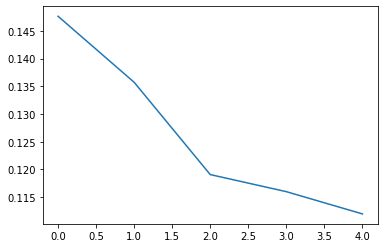

In [ ]:
NUM_EPOCHS = 5
hist = model.fit(val_gen,  epochs=NUM_EPOCHS, steps_per_epoch = steps_per_epoch)

plt.plot(hist.history['loss'])

Epoch 1/5
336/336 [==============================] - 155s 460ms/step - loss: 0.1017 - accuracy: 0.9603
Epoch 2/5
336/336 [==============================] - 154s 459ms/step - loss: 0.0945 - accuracy: 0.9631
Epoch 3/5
336/336 [==============================] - 154s 459ms/step - loss: 0.0895 - accuracy: 0.9650
Epoch 4/5
336/336 [==============================] - 154s 459ms/step - loss: 0.0949 - accuracy: 0.9630
Epoch 5/5
336/336 [==============================] - 154s 458ms/step - loss: 0.0881 - accuracy: 0.9654


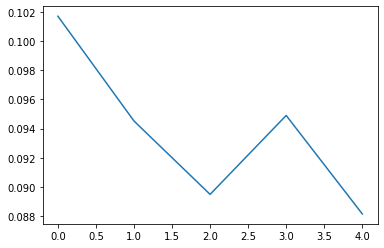

In [ ]:
NUM_EPOCHS = 5
hist = model.fit(val_gen,  epochs=NUM_EPOCHS, steps_per_epoch = steps_per_epoch)

plt.plot(hist.history['loss'])

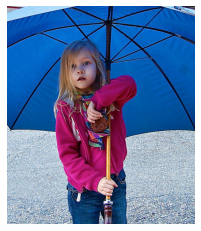

In [ ]:
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
I = io.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))/255.0
# Or use url to load image
# I = io.imread(img['coco_url'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [ ]:
from skimage.transform import rescale, resize, downscale_local_mean

In [ ]:
image_resized = resize(I, (256, 256))

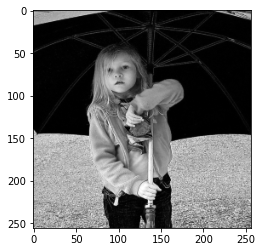

In [ ]:
_=plt.imshow(image_resized[...,0], cmap='gray')

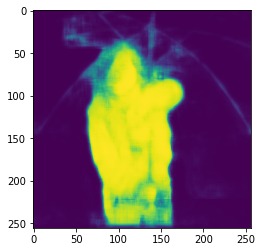

In [ ]:
out = model.predict(image_resized[None, ...])[0, ...]
_=plt.imshow(out[...,0])

In [ ]:
I = io.imread('/content/drive/MyDrive/CV/l4/2021-04-05_16-27-09.png')


In [ ]:
image_resized = resize(I, (256, 256))

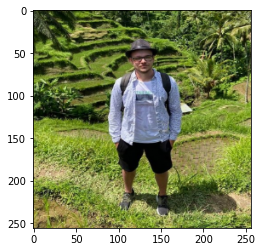

In [ ]:
plt.imshow(image_resized)
plt.show()

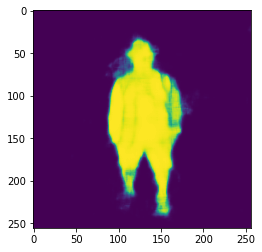

In [ ]:
out = model.predict(image_resized[None, ...])[0, ...]
_=plt.imshow(out[...,0])